<a href="https://colab.research.google.com/github/nightly228/marketplace-LLM/blob/main/osago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === 1. Установка библиотек ===
!pip install pm4py pandas


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 51.4 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26098 sha256=acbcab84ebc18ff9ce0c45a91a933eb02bbca5bb8f87652923268174c04d67bb
  Stored in directory: /root/.cache/pip/wheels/65/c3/c3/238bf93c243597857edd94ddb0577faa74a8e16e9585896e83
Successfully built intervaltree


In [2]:
from google.colab import files
import pandas as pd

# диалоговое окно для загрузки файла
uploaded = files.upload()  # выбери свой CSV файл

# получаем имя файла
filename = list(uploaded.keys())[0]

# читаем CSV
columns = [
    "Номер заявки - ID",
    "Действие по заявке - Событие",
    "Время",
    "Канал",
    "Имя работника",
    "Тип страхового случая",
    "Тип повреждения",
    "Место происшествия",
    "Модель машины",
    "Сумма ущерба",
    "Оценка удовлетворённости клиента"
]

df = pd.read_csv(filename, names=columns, header=None)
print("Файл загружен. Размер датафрейма:", df.shape)



Saving case_championship_last.csv to case_championship_last.csv
Файл загружен. Размер датафрейма: (441550, 11)


In [3]:
# Преобразование времени и переименование колонок под PM4Py
df["Время"] = pd.to_datetime(df["Время"], errors="coerce")
df = df.rename(columns={
    "Номер заявки - ID": "case:concept:name",
    "Действие по заявке - Событие": "concept:name",
    "Время": "time:timestamp"
})

# Проверка качества данных
print("Размер датафрейма:", df.shape)
print("Пропуски по колонкам:\n", df.isna().sum())
dups = df.duplicated(subset=["case:concept:name", "concept:name", "time:timestamp"]).sum()
print(f"Количество дубликатов: {dups}")

df_sorted = df.sort_values(["case:concept:name", "time:timestamp"])

# === 3. Конвертация в event log ===
import pm4py

event_log = pm4py.format_dataframe(
    df_sorted,
    case_id="case:concept:name",
    activity_key="concept:name",
    timestamp_key="time:timestamp"
)

Размер датафрейма: (441550, 11)
Пропуски по колонкам:
 case:concept:name                   0
concept:name                        0
time:timestamp                      0
Канал                               0
Имя работника                       0
Тип страхового случая               0
Тип повреждения                     0
Место происшествия                  0
Модель машины                       0
Сумма ущерба                        0
Оценка удовлетворённости клиента    0
dtype: int64
Количество дубликатов: 0


/usr/local/lib/python3.12/dist-packages/cudf/utils/gpu_utils.py:75: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.12/dist-packages/cudf/pandas/__init__.py:64: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))


In [4]:
print(df.columns.tolist())


['case:concept:name', 'concept:name', 'time:timestamp', 'Канал', 'Имя работника', 'Тип страхового случая', 'Тип повреждения', 'Место происшествия', 'Модель машины', 'Сумма ущерба', 'Оценка удовлетворённости клиента']


In [5]:
# === 5. Анализ SLA ===
import pandas as pd
from pm4py.statistics.traces.generic.log import case_statistics

# считаем длительности кейсов
durations = case_statistics.get_all_case_durations(
    event_log,
    parameters={
        "case_id_key": "case:concept:name",
        "timestamp_key": "time:timestamp"
    }
)

durations = pd.Series(durations)

print("\n📊 SLA-анализ")
print("Средняя длительность (в днях):", round(durations.mean() / 86400, 2))
print("Медианная длительность (в днях):", round(durations.median() / 86400, 2))

# доля заявок в SLA (<= 2 дня)
sla_cases = (durations <= 2*24*60*60).mean()
print("Доля заявок в SLA (<= 2 дня):", round(sla_cases*100, 2), "%")

# === 5. Топ-5 вариантов процесса ===
variants = pm4py.get_variants_as_tuples(event_log)
print("\n🔝 Топ-5 вариантов процесса:")
for v, count in list(variants.items())[:5]:
    print(v, "-", count, "заявок")



📊 SLA-анализ
Средняя длительность (в днях): 1.36
Медианная длительность (в днях): 1.38
Доля заявок в SLA (<= 2 дня): 91.04 %

🔝 Топ-5 вариантов процесса:
('Регистрация претензии', 'Проверка документов', 'Поиск потерянной документации', 'Проверка документов', 'Урегулирование претензии', 'Утверждение претензии', 'Ремонт автомобиля', 'Подготовка итоговой документации', 'Закрытие страхового случая', 'Обзор произошедшего случая') - 3487 заявок
('Регистрация претензии', 'Проверка документов', 'Проверка на мошенничество', 'Урегулирование претензии', 'Урегулирование претензии', 'Утверждение претензии', 'Ремонт автомобиля', 'Подготовка итоговой документации', 'Закрытие страхового случая', 'Обзор произошедшего случая') - 5044 заявок
('Регистрация претензии', 'Проверка документов', 'Урегулирование претензии', 'Утверждение претензии', 'Ремонт автомобиля', 'Подготовка итоговой документации', 'Закрытие страхового случая', 'Обзор произошедшего случая') - 14851 заявок
('Регистрация претензии', 'Прове

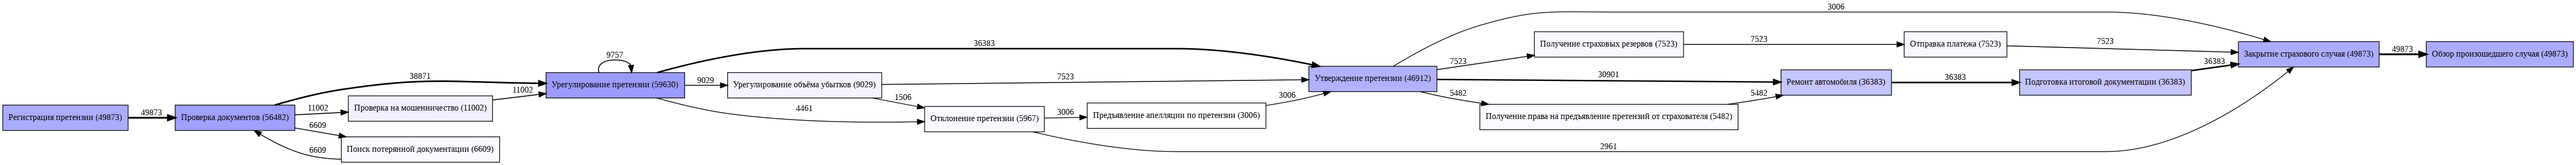

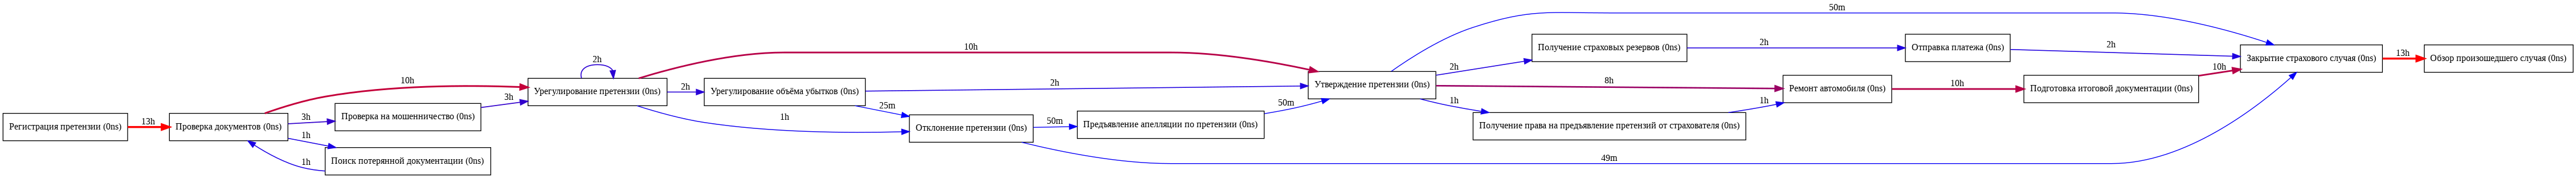

In [8]:
# === 6. Визуализация Directly-Follows Graph (DFG) ===
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.visualization.dfg.variants import frequency, performance

# строим DFG
dfg = dfg_discovery.apply(event_log)

# === Вариант 1: частотный граф (frequency) ===
gviz_freq = dfg_visualization.apply(dfg, log=event_log, variant=frequency)
dfg_visualization.view(gviz_freq)

# === Вариант 2: граф по времени (performance) ===
gviz_perf = dfg_visualization.apply(dfg, log=event_log, variant=performance)
dfg_visualization.view(gviz_perf)


Тип, возвращённый inductive_miner.apply(): <class 'pm4py.objects.process_tree.obj.ProcessTree'>
ProcessTree успешно конвертирован через pm4py.objects.conversion.process_tree.converter.


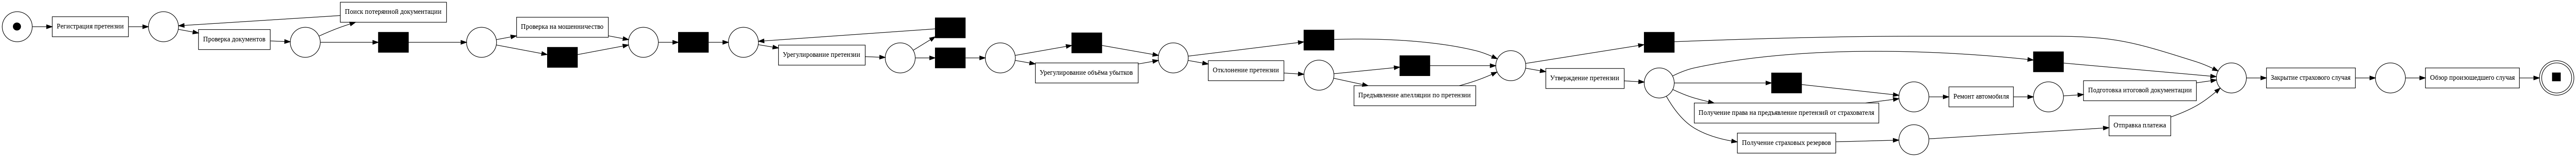

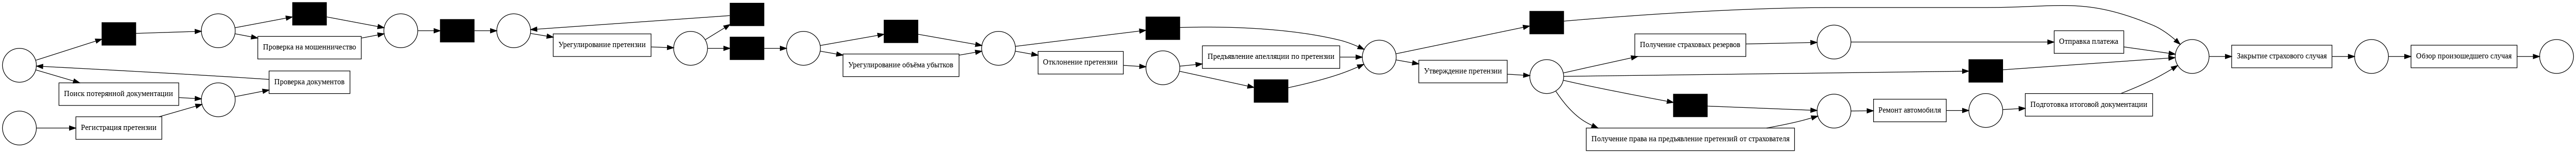

In [24]:
# Обработать оба случая: inductive_miner.apply может вернуть либо (net, im, fm), либо ProcessTree
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.visualization.petri_net import visualizer as pn_visualizer
import pm4py
import inspect

res = inductive_miner.apply(event_log)  # может вернуть ProcessTree или (net, im, fm)
print("Тип, возвращённый inductive_miner.apply():", type(res))

# 1) если вернулся кортеж (net, im, fm) — распакуем его
if isinstance(res, tuple) and len(res) == 3:
    net, initial_marking, final_marking = res
    print("Получили (net, initial_marking, final_marking) напрямую.")
else:
    # 2) иначе считаем, что получили ProcessTree — конвертируем в Petri net
    tree = res
    try:
        # предпочтительный путь: конвертер ProcessTree -> PetriNet
        net, initial_marking, final_marking = pt_converter.apply(tree)  # обычно default variant → to_petri_net
        print("ProcessTree успешно конвертирован через pm4py.objects.conversion.process_tree.converter.")
    except Exception as e:
        print("Первичная конвертация через pt_converter не сработала:", e)
        # запасной вариант: общий helper pm4py.convert_to_petri_net
        try:
            net, initial_marking, final_marking = pm4py.convert.convert_to_petri_net(tree)
            print("ProcessTree успешно конвертирован через pm4py.convert.convert_to_petri_net().")
        except Exception as e2:
            # если и это упало — покажем сообщение и пробросим исключение
            print("Не удалось конвертировать ProcessTree в Petri net. Ошибка:", e2)
            raise

# Визуализация Petri Net
gviz_pn = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz_pn)

gviz_pn = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz_pn)

In [13]:

# === 8. Базовый анализ ресурсов и узких мест ===
# Пример: средняя длительность по исполнителям
resource_times = df_sorted.groupby("Имя работника")["time:timestamp"].agg(['min','max'])
resource_times['duration_days'] = (resource_times['max'] - resource_times['min']).dt.total_seconds()/86400
print("\n⏱ Средняя длительность обработки по исполнителям:")
print(resource_times.sort_values('duration_days', ascending=False))


⏱ Средняя длительность обработки по исполнителям:
                                    min                 max  duration_days
Имя работника                                                             
Геннадий Кривцов    2023-02-04 23:02:17 2025-02-06 13:48:06     732.615150
Леонид Куликов      2023-02-04 22:59:17 2025-02-06 13:33:46     732.607280
Сергей Петров       2023-02-04 22:27:48 2025-02-06 12:33:46     732.587477
Семён Афанасьев     2023-02-04 22:39:34 2025-02-06 11:33:46     732.537639
Ксения Петрова      2023-02-04 22:34:34 2025-02-06 10:33:46     732.499444
Михаил Трофимов     2023-02-05 05:12:36 2025-02-06 10:48:06     732.232986
Денис Прохоров      2023-02-04 22:27:28 2025-02-05 20:00:31     731.897951
Инна Смирнова       2023-02-04 23:04:17 2025-02-05 20:34:45     731.896157
Алексей Лопухин     2023-02-04 23:44:34 2025-02-05 19:34:45     731.826516
Анна Егорова        2023-02-05 03:43:33 2025-02-05 21:00:31     731.720116
Сидоров Илья        2023-02-05 02:24:35 2025-02-0

In [14]:
# === 9. Анализ действий, влияющих на задержки ===
# Среднее время между действиями
df_sorted['next_time'] = df_sorted.groupby("case:concept:name")["time:timestamp"].shift(-1)
df_sorted['duration_sec'] = (df_sorted['next_time'] - df_sorted['time:timestamp']).dt.total_seconds()
avg_durations = df_sorted.groupby("concept:name")["duration_sec"].mean().sort_values(ascending=False)
print("\n⏱ Среднее время на действия (секунды):")
print(avg_durations.head(10))


⏱ Среднее время на действия (секунды):
concept:name
Урегулирование претензии                                     46173.948348
Проверка документов                                          23164.505152
Регистрация претензии                                        11529.998596
Предъявление апелляции по претензии                           5438.323353
Проверка на мошенничество                                     5432.066897
Получение страховых резервов                                  5416.509371
Получение права на предъявление претензий от страхователя     5409.850420
Поиск потерянной документации                                 5405.719473
Утверждение претензии                                         5399.769782
Закрытие страхового случая                                    5397.654041
Name: duration_sec, dtype: float64


In [15]:
from pm4py.statistics.traces.generic.log import case_statistics

# средняя длительность кейсов у нас уже есть
# теперь посчитаем длительность конкретных переходов
from pm4py.algo.discovery.dfg.adapters.pandas import df_statistics

perf_dfg = df_statistics.get_dfg_graph(df, measure="performance")
print("ТОП-10 самых долгих переходов:")
print(sorted(perf_dfg.items(), key=lambda x: -x[1])[:10])


ТОП-10 самых долгих переходов:
[(('Урегулирование претензии', 'Утверждение претензии'), 46591.16510458181), (('Урегулирование претензии', 'Урегулирование претензии'), 45690.58727067746), (('Урегулирование претензии', 'Урегулирование объёма убытков'), 45447.22560637944), (('Урегулирование претензии', 'Отклонение претензии'), 45299.287155346334), (('Проверка документов', 'Проверка на мошенничество'), 24424.171968732957), (('Проверка документов', 'Поиск потерянной документации'), 22972.74625510667), (('Проверка документов', 'Урегулирование претензии'), 22840.574206992358), (('Регистрация претензии', 'Проверка документов'), 11529.998596434945), (('Утверждение претензии', 'Закрытие страхового случая'), 5479.041916167665), (('Предъявление апелляции по претензии', 'Утверждение претензии'), 5438.323353293413)]


In [16]:
cases_per_worker = df.groupby("Имя работника")["case:concept:name"].nunique().sort_values(ascending=False)
print("Топ-10 сотрудников по количеству заявок:")
print(cases_per_worker.head(10))


Топ-10 сотрудников по количеству заявок:
Имя работника
Анна Егорова           37959
Денис Прохоров         32559
Леонид Куликов         32447
Сергей Петров          28540
Сидоров Илья           25173
Алексей Лопухин        24941
Инна Смирнова          23000
Семён Афанасьев        22730
Геннадий Кривцов       20177
Елизавета Нестерова    16247
Name: case:concept:name, dtype: int64


In [21]:
import pandas as pd

# пересчитываем длительности кейсов вручную
cases = (
    df.groupby("case:concept:name")
      .agg(start=("time:timestamp", "min"),
           end=("time:timestamp", "max"))
      .reset_index()
)

cases["duration"] = (cases["end"] - cases["start"]).dt.total_seconds()
cases["days"] = cases["duration"] / 86400

# выбираем кейсы вне SLA (> 2 дней)
bad_cases = cases[cases["days"] > 2]["case:concept:name"].tolist()

df_bad = df[df["case:concept:name"].isin(bad_cases)]

print("ТОП-5 событий в просроченных кейсах:")
print(df_bad["concept:name"].value_counts().head())



ТОП-5 событий в просроченных кейсах:
concept:name
Урегулирование претензии      10468
Проверка документов            6255
Регистрация претензии          4471
Утверждение претензии          4471
Закрытие страхового случая     4471
Name: count, dtype: int64


In [22]:
# === 1. Считаем длительности кейсов ===
cases = (
    df.groupby("case:concept:name")
      .agg(start=("time:timestamp", "min"),
           end=("time:timestamp", "max"))
      .reset_index()
)

cases["duration"] = (cases["end"] - cases["start"]).dt.total_seconds()
cases["days"] = cases["duration"] / 86400

# === 2. Выбираем кейсы вне SLA (>2 дней) ===
bad_cases = cases[cases["days"] > 2]["case:concept:name"].tolist()
df_bad = df[df["case:concept:name"].isin(bad_cases)]

# === 3. Анализ по городам и страховым случаям ===
print("ТОП-5 городов по количеству кейсов вне SLA:")
print(df_bad["Место происшествия"].value_counts().head())

print("\nТОП-5 типов страховых случаев вне SLA:")
print(df_bad["Тип страхового случая"].value_counts().head())



ТОП-5 городов по количеству кейсов вне SLA:
Место происшествия
Екатеринбург       6529
Красноярск         5791
Нижний Новгород    5476
Сочи               4925
Челябинск          4337
Name: count, dtype: int64

ТОП-5 типов страховых случаев вне SLA:
Тип страхового случая
Личный ущерб                             34757
Ответственность перед третьими лицами    13909
Name: count, dtype: int64
